In [1]:
import random

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from algorithm_gd import forward, loss_fn, r2_score, gradient_m, gradient_c, get_iteration_vs_accuracy_data

In [4]:
no_of_nodes = 3

In [5]:
X = [1, 1, 1, 2, 2, 2, 3, 3, 3,  5, 5, 5, 6, 6, 6, 7,7, 7,  9, 9, 9, 10, 10, 10, 11, 11, 11]
y = [2, 2.25, 1.75, 2, 2.25, 1.75, 2, 2.25, 1.75, 6, 6.25, 5.75, 6, 6.25, 5.75, 6, 6.25, 5.75,  10, 9.75, 10.25, 10, 9.75, 10.25, 10, 9.75, 10.25]

Text(0, 0.5, 'Y')

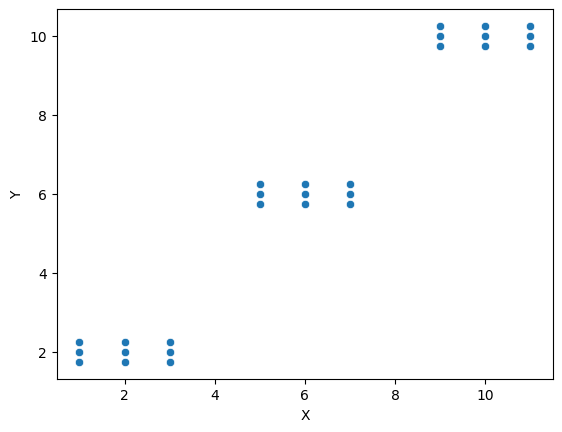

In [6]:
ax = sns.scatterplot(x=X, y=y)
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [7]:
N = len(X) // no_of_nodes
N

9

In [8]:
def gen_test_data_partition(partitions, data):
    data_cp = data.copy()
    random.shuffle(data_cp)
    n = len(data_cp) // partitions
    result = []
    for i in range(partitions):
        result.append(data_cp[i*n:(i+1)*n])
    return result

In [9]:
node_data = []
node_test_samples = [{"X": [], "y": []} for i in range(no_of_nodes)]
for i in range(no_of_nodes):
    X_node = X[i*N:(i+1)*N]
    y_node = y[i*N:(i+1)*N]
    node_data.append({"X": X_node, "y": y_node})
    node_data[-1]["y_mean"] = sum(node_data[-1]["y"])/len(node_data[-1]["y"])
    test_samples = gen_test_data_partition(no_of_nodes, list(zip(X_node, y_node)))
    for j, node_test_sample in enumerate(test_samples):
        for test_sample in node_test_sample:
            node_test_samples[j]["X"].append(test_sample[0])
            node_test_samples[j]["y"].append(test_sample[1])

for i in range(no_of_nodes):
    node_test_samples[i]["y_mean"] = sum(node_test_samples[i]["y"])/len(node_test_samples[i]["y"])

# node_data, node_test_samples

In [10]:
node_params = [ {"m": 0, "c": 0, "norm_m": 0, "norm_c": 0} for i in range(no_of_nodes)]
node_params

[{'m': 0, 'c': 0, 'norm_m': 0, 'norm_c': 0},
 {'m': 0, 'c': 0, 'norm_m': 0, 'norm_c': 0},
 {'m': 0, 'c': 0, 'norm_m': 0, 'norm_c': 0}]

In [11]:
iterations = 1000

In [12]:
L = 0.005 # learning rate

In [13]:
# doubly_stochastic_matrix_config = [
#     [1/2, 1/4, 1/4],
#     [1/4, 0, 3/4],
#     [1/4, 3/4, 0]
# ]

doubly_stochastic_matrix_config = [
    [2/3, 1/6, 1/6],
    [1/6, 1/6, 2/3],
    [1/6, 2/3, 1/6]
]

In [14]:
steps_data = []
accuracy_data = [
    [] for i in range(no_of_nodes)
]
accuracy_norm_data = [
    [] for i in range(no_of_nodes)
]

In [15]:
for i in range(1, iterations+1):
    steps_data.append(i)
    prev_node_params = node_params.copy()
    for node_id in range(no_of_nodes):
        params = node_params[node_id]
        
        X_node = node_data[node_id]["X"]
        y_node = node_data[node_id]["y"]
    
        X_node_test = node_test_samples[node_id]["X"]
        y_node_test = node_test_samples[node_id]["y"]
        y_node_test_mean = node_test_samples[node_id]["y_mean"]

        y_node_test_pred = forward(X_node_test, params)
        y_node_test_norm_pred = forward(X_node_test, {"m": params["norm_m"], "c": params["norm_c"]})
        
        y_node_pred = forward(X_node, params)
        y_node_norm_pred = forward(X_node, {"m": params["norm_m"], "c": params["norm_c"]})
        
        # loss = loss_fn(y_node_test, y_node_test_pred)
        accuracy = r2_score(y_node_test, y_node_test_mean, y_node_test_pred)
        accuracy_data[node_id].append(accuracy)
        # print("Node:", node_id, "| Loss:", round(loss, 6), "| Accuracy:", round(accuracy, 6))

        accuracy = r2_score(y_node_test, y_node_test_mean, y_node_test_norm_pred)
        accuracy_norm_data[node_id].append(accuracy)
    
        grad_m = gradient_m(X_node, y_node, y_node_pred)
        grad_c = gradient_c(y_node, y_node_pred)

        # normalized_grad_m = np.round(gradient_m(X_node, y_node, y_node_norm_pred), decimals=1)
        # normalized_grad_c = np.round(gradient_c(y_node, y_node_norm_pred), decimals=1)
        normalized_grad_c = grad_c
        doubly_st_mt = doubly_stochastic_matrix_config[node_id]

        numerator = (doubly_st_mt[node_id] - 1) * prev_node_params[node_id]["norm_m"]
        denominator = L

        for i in set(range(no_of_nodes)) - {node_id}:
            numerator += doubly_st_mt[i] * prev_node_params[i]["norm_m"]

        grad_m_node_p_step = (numerator + 0.1)
        grad_m_node_m_step = (numerator - 0.1)

        # print(grad_m, grad_c, end='    ')
        print(grad_m, grad_m_node_p_step, grad_m_node_m_step)
        
        if abs(grad_m - grad_m_node_p_step) < abs(grad_m - grad_m_node_m_step):
            normalized_grad_m = grad_m_node_p_step
        else:
            normalized_grad_m = grad_m_node_m_step

        print(normalized_grad_m)

        params['m'] = sum( frac*prev_node_params[i]["m"] for i, frac in enumerate(doubly_st_mt) ) - L * grad_m
        params['c'] = sum( frac*prev_node_params[i]["c"] for i, frac in enumerate(doubly_st_mt) ) - L * grad_c

        params['norm_m'] = sum( frac*prev_node_params[i]["norm_m"] for i, frac in enumerate(doubly_st_mt) ) - L * normalized_grad_m
        params['norm_c'] = sum( frac*prev_node_params[i]["norm_c"] for i, frac in enumerate(doubly_st_mt) ) - L * normalized_grad_c

    # print(node_params)

-8.0 0.1 -0.1
-0.1
-72.0 0.10008333333333334 -0.09991666666666667
-0.09991666666666667
-200.0 0.10047194444444445 -0.09952805555555556
-0.09952805555555556
-7.546666666666667 0.10009208356481482 -0.09990791643518519
-0.09990791643518519
-44.35111111111111 0.10034256311709105 -0.09965743688290896
-0.09965743688290896
54.80148148148147 0.10032312790142811 -0.0996768720985719
0.10032312790142811
-4.613797530864198 0.10000526960972234 -0.09999473039027768
-0.09999473039027768
15.865379423868308 0.099607069917396 -0.10039293008260401
0.099607069917396
-42.32622441700963 0.0999620979386456 -0.1000379020613544
-0.1000379020613544
-2.272371361682671 0.09976540885862466 -0.10023459114137535
-0.10023459114137535
-17.504390899558008 0.10070216304591198 -0.09929783695408803
-0.09929783695408803
-12.392155777269714 0.10042039018736217 -0.09957960981263785
-0.09957960981263785
-1.3300298175345915 0.1000293716650321 -0.0999706283349679
-0.0999706283349679
-1.9920248951770136 0.10040368247907802 -0.09

In [16]:
Xy_test = gen_test_data_partition(no_of_nodes, list(zip(X, y)))[random.randint(0, no_of_nodes-1)]
X_test = []
y_test = []
for Xy in Xy_test:
    X_test.append(Xy[0])
    y_test.append(Xy[1])

gd_iterations, gd_accuracy, _ = get_iteration_vs_accuracy_data(X, y, iterations, X_test=X_test, y_test=y_test, L=L)

<Axes: title={'center': 'Iteration vs Accuracy (10000 iterations)'}, xlabel='Iteration', ylabel='Accuracy'>

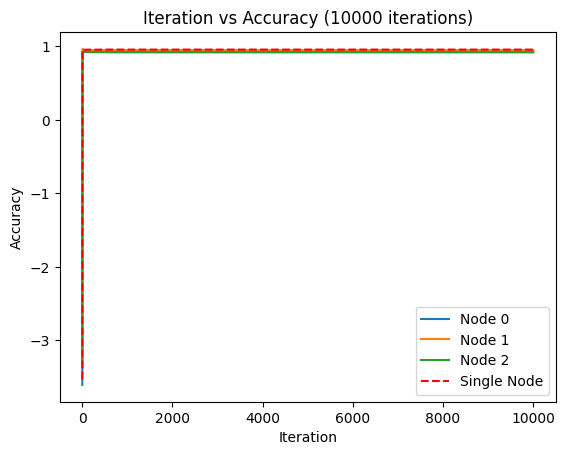

In [17]:
data = {f'Node {i}': accuracy_data[i] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data, **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")
ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')
ax.set_title(f"Iteration vs Accuracy ({iterations} iterations)")
sns.lineplot(x=gd_iterations, y=gd_accuracy, linestyle='--', color='r', label='Single Node')

<Axes: title={'center': 'Iteration vs Accuracy, Roundoff Gradient (10000 iterations)'}, xlabel='Iteration', ylabel='Accuracy'>

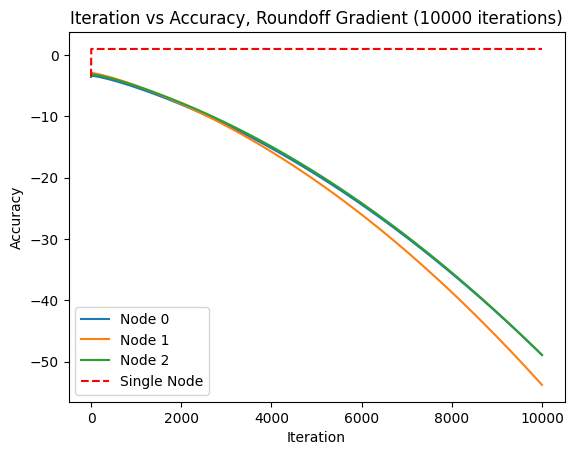

In [18]:
data = {f'Node {i}': accuracy_norm_data[i] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data, **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")
ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')
ax.set_title(f"Iteration vs Accuracy, Roundoff Gradient ({iterations} iterations)")
sns.lineplot(x=gd_iterations, y=gd_accuracy, linestyle='--', color='r', label='Single Node')

<Axes: title={'center': 'Iteration vs Accuracy (200 - 500 iterations)'}, xlabel='Iteration', ylabel='Accuracy'>

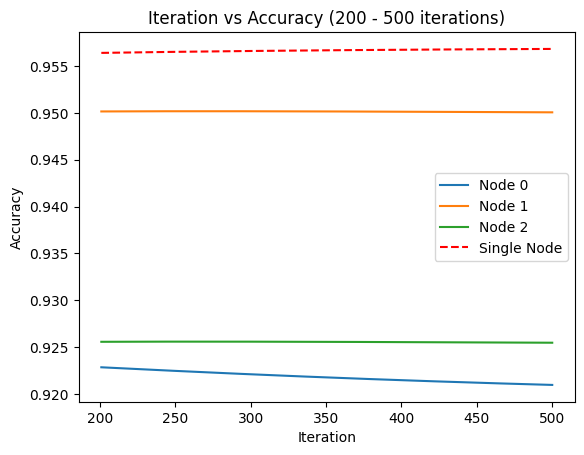

In [19]:
iteration_start = 200
iterations_sample = 500
data = {f'Node {i}': accuracy_data[i][iteration_start:iterations_sample] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data[iteration_start:iterations_sample], **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")

ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')
ax.set_title(f"Iteration vs Accuracy ({iteration_start} - {iterations_sample} iterations)")

sns.lineplot(x=gd_iterations[iteration_start:iterations_sample], y=gd_accuracy[iteration_start:iterations_sample], linestyle='--', color='r', label='Single Node')

Text(0.5, 1.0, 'Iteration vs Accuracy (10000 iterations) - Gradient descent in single node')

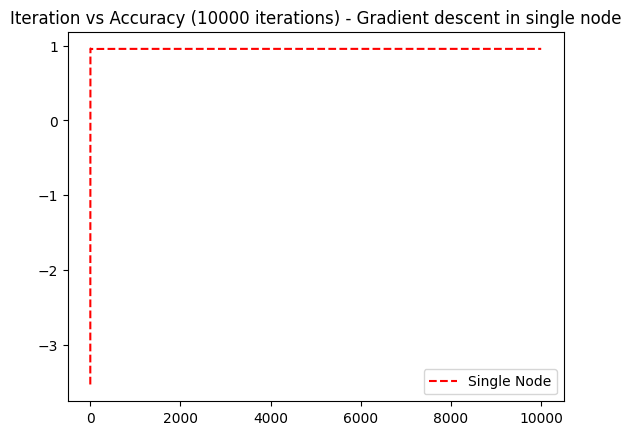

In [20]:
ax = sns.lineplot(x=gd_iterations, y=gd_accuracy, linestyle='--', color='r', label='Single Node')
ax.set_title(f"Iteration vs Accuracy ({iterations} iterations) - Gradient descent in single node")

In [21]:
params

{'m': 0.9320981553107233,
 'c': 0.46309556479319836,
 'norm_m': -2.4858453149425435,
 'norm_c': 0.46309556479319836}